## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
import soccerdata as sd
import re
from unidecode import unidecode

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "black"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

[10/28/24 15:56:20] INFO     No custom team name replacements found. You can configure these in       ]8;id=475907;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=578614;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#87\87]8;;\
                             C:\Users\acer\soccerdata\config\teamname_replacements.json.                           

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=11943;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=691394;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#177\177]8;;\
                             C:\Users\acer\soccerdata\config\league_dict.json.                                     

In [2]:
import matplotlib.font_manager as fm
from mplsoccer import FontManager

# Set the path to the locally downloaded font file
font_path = r'C:\Users\acer\Documents\GitHub\IndianCitizen\ScorePredict\Score Logos-20241022T100701Z-001\Score Logos\Sora_Font\Sora-Regular.ttf'

# Add the font to matplotlib
font_prop = fm.FontProperties(fname=font_path)

# You can now use this font in your plots
fm_sora = FontManager()
#fm_sora.prop = font_prop

print("Font loaded and registered successfully!")

Font loaded and registered successfully!


## Extracting Data

### FotMob

In [78]:
def scrape_stats(mi):
    params = {'matchId': mi}
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
    data = response.json()
    hometeam = data['general']['homeTeam']['name']
    awayteam = data['general']['awayTeam']['name']
    shotmap = data['content']['shotmap']['shots']
    top_stats = data['content']['stats']['Periods']['All']['stats'][0]['stats']
    pass_stats = data['content']['stats']['Periods']['All']['stats'][3]['stats']
    defensive_stats = data['content']['stats']['Periods']['All']['stats'][4]['stats']
    stats_df = pd.DataFrame(top_stats)
    passstats_df = pd.DataFrame(pass_stats)
    defensestats_df = pd.DataFrame(defensive_stats)
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi
    stats_df['matchId'] = mi
    passstats_df['matchId'] = mi
    defensestats_df['matchId'] = mi
    return shots_df,stats_df,passstats_df,defensestats_df,hometeam,awayteam

In [79]:
df_shots,stats_df,passstats_df,defensestats_df,hometeam,awayteam = scrape_stats(4535413)

### WhoScored

In [333]:
ws = sd.WhoScored(leagues="ENG-Premier League", seasons="2024-25")

[10/24/24 14:19:49] INFO     Saving cached data to C:\Users\acer\soccerdata\data\WhoScored            ]8;id=594025;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=16229;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py#91\91]8;;\

In [3]:
match_html_path = "C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/HTMLs/Real MadridVBarcelona.html"

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

In [77]:
# Put the match HTML file path here
match_html_path = "C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/HTMLs/InterVJuventus.html"

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

# Extract the 'displayName' value
df['type'] = df['type'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)
df['outcomeType'] = df['outcomeType'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)
df['period'] = df['period'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)

# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})

# new column for cumulative minutes, This part is taken from the "jakeyk11.github.io" github repository and modified for my use
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()

    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
# xT = pd.read_csv("/content/xT_Grid.csv", header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'outcomeType', 'qualifiers',  'type',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot', 'cumulative_mins']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

# New Column for Team Names and Oppositon TeamNames
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats',
                   'subbedInPlayerId', 'subbedOutPeriod',
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

# adding player name, shirt no. etc info
df = df.merge(dfp, on='playerId', how='left')

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'),
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'),
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['name'] = df['name'].astype(str)
df['name'] = df['name'].apply(unidecode)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['name'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['id']
df.drop(columns=columns_to_drop2, inplace=True)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime',
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

C:\Users\acer\AppData\Local\Temp\ipykernel_2820\2067693143.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\2067693143.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\2067693143.py:207: FutureWarning: Series.__getitem__ treating keys as posit

In [5]:
df.columns

Index(['index', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal_x', 'cardType_x',
       'isOwnGoal_x', 'cumulative_mins', 'isGoal_y', 'cardType_y',
       'isOwnGoal_y', 'x1_bin_xT', 'y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT',
       'start_zone_value_xT', 'end_zone_value_xT', 'xT', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'prog_pass', 'prog_carry', 'pass_or_carry_angle', 'shortName'],
      dtype='object')

## Offsides

In [57]:
df_offside_pass = df[(df['type'] == 'OffsidePass') & (df['teamName'] == 'Real Madrid')]
df_offside_prov = df[(df['type'] == 'OffsideProvoked') & (df['teamName'] == 'Barcelona')]
df_offside = df[(df['type'] == 'OffsideGiven') & (df['teamName'] == 'Real Madrid')]

In [26]:
df_offside.columns

Index(['index', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal_x', 'cardType_x',
       'isOwnGoal_x', 'cumulative_mins', 'isGoal_y', 'cardType_y',
       'isOwnGoal_y', 'x1_bin_xT', 'y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT',
       'start_zone_value_xT', 'end_zone_value_xT', 'xT', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'prog_pass', 'prog_carry', 'pass_or_carry_angle', 'shortName'],
      dtype='object')

In [58]:
df_offside['pair_id'] = range(1, len(df_offside) + 1)
df_offside_prov['pair_id'] = range(1, len(df_offside_prov) + 1)

C:\Users\acer\AppData\Local\Temp\ipykernel_2820\845099622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offside['pair_id'] = range(1, len(df_offside) + 1)
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\845099622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offside_prov['pair_id'] = range(1, len(df_offside_prov) + 1)


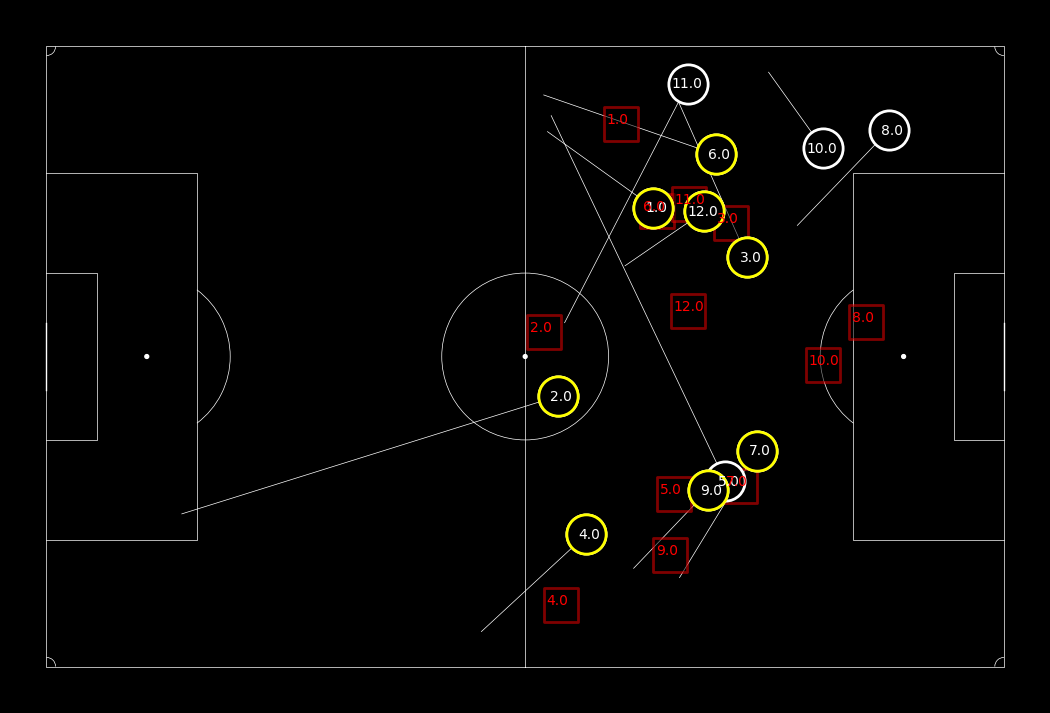

In [74]:
fig,ax=plt.subplots(figsize=(16,9), facecolor=background)
pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
pitch.draw(ax=ax)

for index,row in df_offside.iterrows():
    if row['teamName'] == 'Real Madrid':
        pitch.scatter(row['x'],row['y'],s=800, marker='o', color=background, edgecolor='white', linewidth=2,zorder=3, alpha=1, ax=ax)

for index,row in df_offside.iterrows():
    if row['name'] == 'Kylian Mbappe':
        pitch.scatter(row['x'],row['y'],s=800, marker='o', color=background, edgecolor='yellow', linewidth=2,zorder=3, alpha=1, ax=ax)

for index,row in df_offside_pass.iterrows():
    if row['teamName'] == 'Real Madrid':
        pitch.lines(row.x, row.y, row.endX, row.endY,lw=0.5, color='white', zorder=2, ax=ax)

for index,row in df_offside_prov.iterrows():
    if row['teamName'] == 'Barcelona':
        pitch.scatter(105-row['x'],68-row['y'],s=600, marker='s', color=background, edgecolor='red', linewidth=2,zorder=2, alpha=0.5, ax=ax)

# Annotate each pair with a number

for i, (x, y, pair_id) in df_offside[['x', 'y', 'pair_id']].iterrows():
    ax.text(x+1.55, y-0.5, str(pair_id), color='white', fontsize=10, ha='right')

for i, (x, y, pair_id) in df_offside_prov[['x', 'y', 'pair_id']].iterrows():
    ax.text(105 - (x+1.55), 68 -y, str(pair_id), color='red', fontsize=10, ha='left')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Offsides.png',dpi=500,bbox_inches = 'tight',facecolor=background)

In [76]:
df_offside['name'].value_counts()

name
Kylian Mbappe      8
Vinicius Junior    3
Jude Bellingham    1
Name: count, dtype: int64

In [75]:
df_offside_prov['name'].value_counts()

name
Pau Cubarsi        4
Inigo Martinez     4
Jules Kounde       2
Alejandro Balde    2
Name: count, dtype: int64

## ShotMaps

In [67]:
df_shots.columns

Index(['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min',
       'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY',
       'goalCrossedY', 'goalCrossedZ', 'expectedGoals',
       'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal',
       'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'firstName',
       'lastName', 'fullName', 'teamColor', 'matchId'],
      dtype='object')

In [69]:
df_shots['shotType'].unique()

array(['RightFoot', 'LeftFoot', 'Header'], dtype=object)

In [80]:
pitch = Pitch(pitch_type='custom',pitch_length = 105,pitch_width = 68, line_zorder=2
              ,pitch_color='black', line_color='white')

# subset the shots for each team
team1, team2 = df_shots.teamId.unique()
#teamcolor1,teamcolor2 = df_shots.teamColor.unique()
df_team1 = df_shots[(df_shots.teamId == team1) & (df_shots.eventType != 'Goal') & (df_shots.shotType != 'Header')].copy()
df_team2 = df_shots[(df_shots.teamId == team2) & (df_shots.eventType != 'Goal') & (df_shots.shotType != 'Header')].copy()

df_team1_goals = df_shots[(df_shots.teamId == team1) & (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal != True)].copy()
df_team2_goals = df_shots[(df_shots.teamId == team2) & (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal != True)].copy()

df_team1_own_goals = df_shots[(df_shots.teamId == team1) & (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal == True)].copy()
df_team2_own_goals = df_shots[(df_shots.teamId == team2) & (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal == True)].copy()

df_team1_headers = df_shots[(df_shots.teamId == team1) & (df_shots.shotType == 'Header')].copy()
df_team2_headers = df_shots[(df_shots.teamId == team2) & (df_shots.shotType == 'Header')].copy()

xG_list = stats_df[stats_df['title'] == 'Expected goals (xG)'].stats.tolist()
team1_xg,team2_xg = xG_list[0]
team1_xg = float(team1_xg)
team2_xg = float(team2_xg)

team1_goals = df_team1_goals.shape[0]
team2_goals = df_team2_goals.shape[0]

if df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0] > 0:
    team2_goals += df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0]
elif df_team2_goals[(df_team2_goals['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0] > 0:
    team1_goals += df_team2_goals[(df_team2['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0]

shots_list = stats_df[stats_df['title'] == 'Total shots'].stats.tolist()
team1_shots,team2_shots = shots_list[0]

shots_ot_list = stats_df[stats_df['title'] == 'Shots on target'].stats.tolist()
team1_shots_ot,team2_shots_ot = shots_ot_list[0]

possession = stats_df[stats_df['title'] == 'Ball possession'].stats.tolist()
team1_pos,team2_pos = possession[0]

acc_passes = stats_df[stats_df['title'] == 'Accurate passes'].stats.tolist()
team1_acc_passes,team2_acc_passes = acc_passes[0]

def string_value(str):
    # The input string
    input_string = str
    match = re.search(r'\((\d+)%\)', input_string) 
    if match:
        percentage_value = int(match.group(1))
    else:
        print("No match found")
    return percentage_value

team1_acc_passes = string_value(team1_acc_passes)
team2_acc_passes = string_value(team2_acc_passes)
saves = defensestats_df[defensestats_df['title'] == 'Keeper saves'].stats.tolist()
team1_saves,team2_saves = saves[0]

# Usually in football, the data is collected so the attacking direction is left to right.
# We can shift the coordinates via: new_x_coordinate = right_side - old_x_coordinate
# This is helpful for having one team shots on the left of the pitch and the other on the right
df_team1['x'] = pitch.dim.right - df_team1.x
df_team1_goals['x'] = pitch.dim.right - df_team1_goals.x
df_team1_own_goals['x'] = pitch.dim.right - df_team1_goals.x
df_team1_headers['x'] = pitch.dim.right - df_team1_goals.x

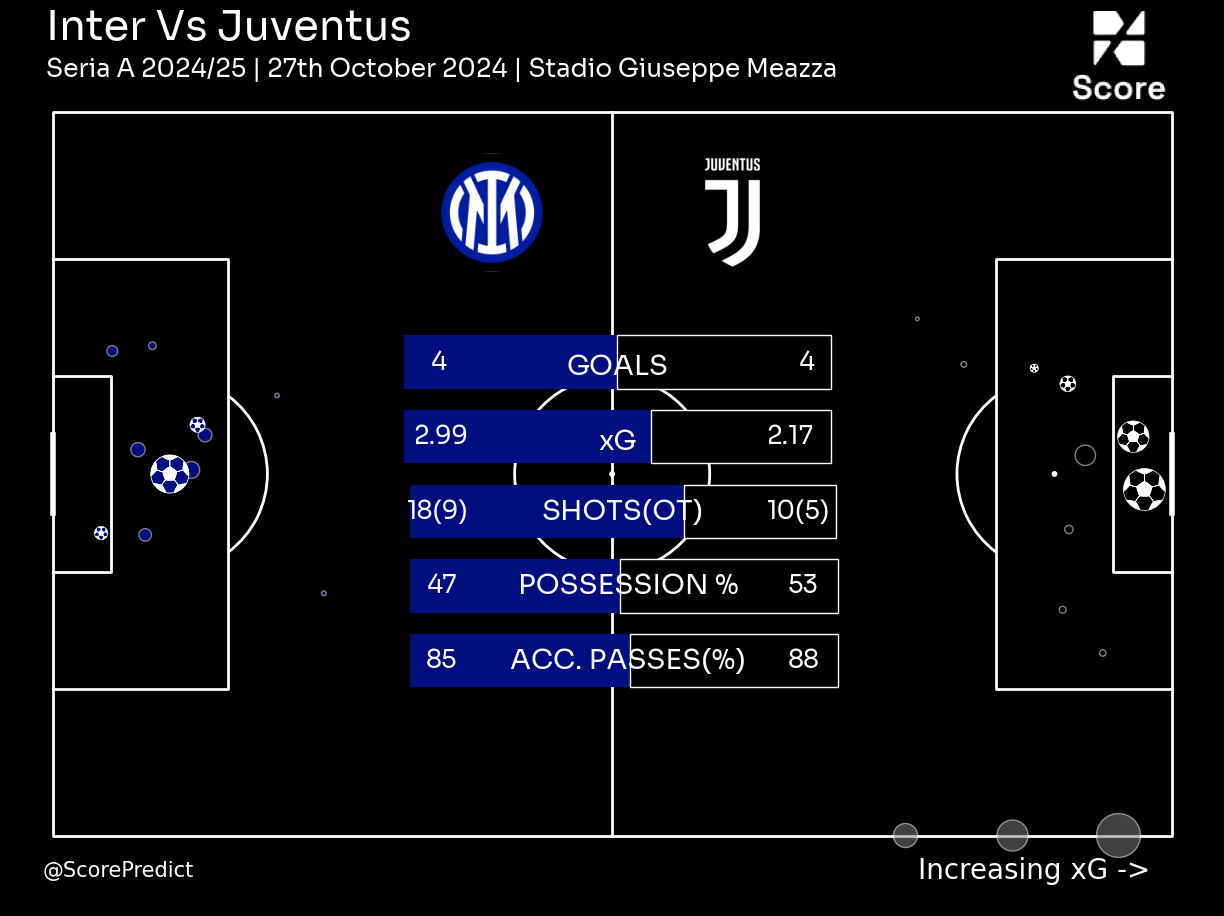

In [88]:
fig, axs = pitch.grid(grid_height=0.9, title_height=0.04, axis=False,
                     endnote_height=0.03, title_space=0, endnote_space=0)  # grid takes up 80% of the figure height


team1 = 'Inter'
team2 = 'Juventus'
#C:\Users\acer\Documents\GitHub\IndianCitizen\Images\TeamLogos
img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{team1}.png')
img_team2 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{team2}.png')
logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')

ax_image = add_image(
    img_team1, fig, left=0.33, bottom=0.7, width=0.15, height=0.17,aspect='equal'
)

ax_image = add_image(
    img_team2, fig, left=0.52, bottom=0.7, width=0.15, height=0.17,aspect='equal'
)

ax_image = add_image(
    logo, fig, left=0.85, bottom=0.9, width=0.1, height=0.11,aspect='equal'
)

team1_facecolor = '#010E80'
team2_facecolor = '#000000'


pitch.scatter(80,0.1,s=300,ec='white',color='grey',ax=axs['pitch'],alpha=0.5,zorder=2)
pitch.scatter(90,0.1,s=500,ec='white',color='grey',ax=axs['pitch'],alpha=0.5,zorder=2)
pitch.scatter(100,0.1,s=1000,ec='white',color='grey',ax=axs['pitch'],alpha=0.5,zorder=2)

sc_team1 = pitch.scatter(df_team1.x, df_team1.y, s=df_team1.expectedGoals * 800,
                         edgecolors='grey', c=team1_facecolor, ax=axs['pitch'],zorder=2)
sc_team1_goals = pitch.scatter(df_team1_goals.x, df_team1_goals.y, s=df_team1_goals.expectedGoals * 1000,
                         edgecolors='white', c=team1_facecolor,marker='football', ax=axs['pitch'],zorder=2)
sc_team1_headers = pitch.scatter(df_team1_headers.x, df_team1_headers.y, s=df_team1_headers.expectedGoals * 800,
                         edgecolors='yellow', c=team1_facecolor,marker='o', ax=axs['pitch'],zorder=2)
sc_team2 = pitch.scatter(df_team2.x, df_team2.y, s=df_team2.expectedGoals * 800,
                         edgecolors='grey', c=team2_facecolor, ax=axs['pitch'],zorder=2)
sc_team2_goals = pitch.scatter(df_team2_goals.x, df_team2_goals.y, s=df_team2_goals.expectedGoals * 1000,
                         edgecolors='white', c=team2_facecolor,marker='football', ax=axs['pitch'],zorder=2)
sc_team2_headers = pitch.scatter(df_team2_headers.x, df_team2_headers.y, s=df_team2_headers.expectedGoals * 800,
                         edgecolors='yellow', c=team2_facecolor,marker='o', ax=axs['pitch'],zorder=2)

fig.set_facecolor('black')


# Set title
axs['pitch'].text(0.03,1.05,f'{team1} Vs {team2}',ha='left', va='center', transform=axs['pitch'].transAxes, color='white',fontsize=30,fontproperties=font_prop)
# Add subtitle
subtitle_text = "Seria A 2024/25 | 27th October 2024 | Stadio Giuseppe Meazza"
axs['pitch'].text(0.03,1, subtitle_text, ha='left', va='center', transform=axs['pitch'].transAxes, color='white', fontsize=18,fontproperties=font_prop)


goals_team1 = team1_goals
goals_team2 = team2_goals

# Calculate the width of the rectangle for each team
total_goals = goals_team1 + goals_team2

# Define the minimum width for the rectangles
min_rect_width = 7

# Coordinates for the rectangle
rect_x = 33 # X-coordinate of the left side of the rectangle
rect_y = 42  # Y-coordinate of the top side of the rectangle
rect_width = 40  # Width of the rectangle
rect_height = 5  # Height of the rectangle

# Calculate the width of the rectangle for each team
# Calculate the width of the rectangle for each team
if goals_team1 == 0 and goals_team2 > 0:
    # If the home team scored 0 goals and the away team scored greater than 0
    width_team1 = 0
    width_team2 = 1
elif goals_team1 > 0 and goals_team2 == 0:
    # If the away team scored 0 goals and the home team scored greater than 0
    width_team1 = 1
    width_team2 = 0
elif total_goals > 0:
    # If both teams scored some goals
    width_team1 = max(goals_team1 / total_goals, min_rect_width / rect_width)
    width_team2 = max(goals_team2 / total_goals, min_rect_width / rect_width)
else:
    # Both teams scored 0 goals, set equal width for both
    width_team1 = 0.5
    width_team2 = 0.5


# Create a rectangle patch for team1
rect_team1 = Rectangle((rect_x, rect_y), width_team1 * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
rect_team2 = Rectangle((rect_x + width_team1 * rect_width, rect_y), width_team2 * rect_width, rect_height, facecolor=team2_facecolor,edgecolor='white',zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(rect_team1)
axs['pitch'].add_patch(rect_team2)

# Calculate the position for 'GOALS' text
goals_text_x = rect_x + width_team1 * rect_width + (width_team2 * rect_width - width_team1 * rect_width) / 2
goals_text_y = rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(37, rect_y + rect_height / 2, str(goals_team1), color='white', ha='right', va='center',fontsize=18,fontproperties=font_prop)
axs['pitch'].text(53, 44, 'GOALS', color = 'white', ha='center', va='center',fontsize=20,fontproperties=font_prop,zorder=2)
axs['pitch'].text(70, rect_y + rect_height / 2, str(goals_team2), color = 'white', ha='left', va='center',fontsize=18,fontproperties=font_prop)

#### Adding xG

# Calculate the width of the rectangle for each team
total_xG = team1_xg + team2_xg
width_team1_xG = team1_xg / total_xG
width_team2_xG = team2_xg / total_xG

if width_team2_xG < 0.05:
    width_team1_xG = 1
    width_team2_xG = 0.05
elif width_team1_xG < 0.05:
    width_team2_xG = 1
    width_team1_xG = 0.05
    

# Coordinates for the rectangle
xG_rect_x = 33 # X-coordinate of the left side of the rectangle
xG_rect_y = 35 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
xG_rect_team1 = Rectangle((xG_rect_x, xG_rect_y), width_team1_xG * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
xG_rect_team2 = Rectangle((xG_rect_x + width_team1_xG * rect_width, xG_rect_y), width_team2_xG * rect_width, rect_height,edgecolor='white', facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(xG_rect_team1)
axs['pitch'].add_patch(xG_rect_team2)

# Add labels for teams' goals
axs['pitch'].text(39, xG_rect_y + rect_height / 2, str(team1_xg), color = 'white', ha='right', va='center',fontsize=18,fontproperties=font_prop)
axs['pitch'].text(53, 37, 'xG', color = 'white', ha='center', va='center',fontsize=20,fontproperties=font_prop)
axs['pitch'].text(67, xG_rect_y + rect_height / 2, str(team2_xg), color = 'white', ha='left', va='center',fontsize=18,fontproperties=font_prop)


#### Adding Shots
shots_team1 = team1_shots
shots_team2 = team2_shots

shots_team1_ot = team1_shots_ot
shots_team2_ot = team2_shots_ot

# Calculate the width of the rectangle for each team
total_shots = shots_team1 + shots_team2
width_team1_shots = shots_team1 / total_shots
width_team2_shots = shots_team2 / total_shots

if width_team2_shots < 0.05:
    width_team1_shots = 1
    width_team2_shots = 0.05
elif width_team1_shots < 0.05:
    width_team2_shots = 1
    width_team1_shots = 0.05

# Coordinates for the rectangle
shots_rect_x = 33.5 # X-coordinate of the left side of the rectangle
shots_rect_y = 28 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
shots_rect_team1 = Rectangle((shots_rect_x, shots_rect_y), width_team1_shots * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
shots_rect_team2 = Rectangle((shots_rect_x + width_team1_shots * rect_width, shots_rect_y), width_team2_shots * rect_width, rect_height,edgecolor='white', facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(shots_rect_team1)
axs['pitch'].add_patch(shots_rect_team2)

# Calculate the position for 'GOALS' text
shots_text_x = shots_rect_x + width_team1_shots * rect_width + (width_team2_shots * rect_width - width_team1_shots * rect_width) / 2
shots_text_y = shots_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(39, shots_rect_y + rect_height / 2, str(shots_team1) + '(' + str(shots_team1_ot) + ')', color = 'white', ha='right', va='center',fontsize=18,fontproperties=font_prop)
axs['pitch'].text(shots_text_x, shots_text_y, 'SHOTS(OT)', color = 'white', ha='center', va='center',fontsize=20,fontproperties=font_prop)
axs['pitch'].text(67, shots_rect_y + rect_height / 2, str(shots_team2) + '(' + str(shots_team2_ot) + ')', color = 'white', ha='left', va='center',fontsize=18,fontproperties=font_prop)


#### Adding possesion
# Calculate the width of the rectangle for each team
total_possesion = team1_pos + team2_pos
width_team1_possesion = (team1_pos / total_possesion)*1.05
width_team2_possesion = team2_pos / total_possesion

# Coordinates for the rectangle
possesion_rect_x = 33.5 # X-coordinate of the left side of the rectangle
possesion_rect_y = 21 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
possesion_rect_team1 = Rectangle((possesion_rect_x, possesion_rect_y), width_team1_possesion * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
possesion_rect_team2 = Rectangle((possesion_rect_x + width_team1_possesion * rect_width, possesion_rect_y), width_team2_possesion * (rect_width-1.5), rect_height, facecolor=team2_facecolor,edgecolor='white',zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(possesion_rect_team1)
axs['pitch'].add_patch(possesion_rect_team2)

# Calculate the position for 'GOALS' text
possesion_text_x = possesion_rect_x + width_team1_possesion * rect_width + (width_team2_possesion * rect_width - width_team1_possesion * rect_width) / 2
possesion_text_y = possesion_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, possesion_rect_y + rect_height / 2, str(team1_pos), color = 'white', ha='right', va='center',fontsize=18,fontproperties=font_prop)
axs['pitch'].text(possesion_text_x, possesion_text_y, 'POSSESSION %', color = 'white', ha='center', va='center',fontsize=20,fontproperties=font_prop)
axs['pitch'].text(69, possesion_rect_y + rect_height / 2, str(team2_pos), color = 'white', ha='left', va='center',fontsize=18,fontproperties=font_prop)


#### Adding Accurate Passes
# Calculate the width of the rectangle for each team
total_acc_passes = team1_acc_passes + team2_acc_passes
width_team1_acc_passes = (team1_acc_passes / total_acc_passes)*1.05
width_team2_acc_passes = team2_acc_passes / total_acc_passes

# Coordinates for the rectangle
acc_passes_rect_x = 33.5 # X-coordinate of the left side of the rectangle
acc_passes_rect_y = 14 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
acc_passes_rect_team1 = Rectangle((acc_passes_rect_x, acc_passes_rect_y), width_team1_acc_passes * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
acc_passes_rect_team2 = Rectangle((acc_passes_rect_x + width_team1_acc_passes * rect_width, acc_passes_rect_y), width_team2_acc_passes * (rect_width-1.5), rect_height, facecolor=team2_facecolor,edgecolor='white',zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(acc_passes_rect_team1)
axs['pitch'].add_patch(acc_passes_rect_team2)

# Calculate the position for 'GOALS' text
acc_passes_text_x = acc_passes_rect_x + width_team1_acc_passes * rect_width + (width_team2_acc_passes * rect_width - width_team1_acc_passes * rect_width) / 2
acc_passes_text_y = acc_passes_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, acc_passes_rect_y + rect_height / 2, str(team1_acc_passes), color = 'white', ha='right', va='center',fontsize=18,fontproperties=font_prop)
axs['pitch'].text(acc_passes_text_x, acc_passes_text_y, 'ACC. PASSES(%)', color = 'white', ha='center', va='center',fontsize=20,fontproperties=font_prop)
axs['pitch'].text(69, acc_passes_rect_y + rect_height / 2, str(team2_acc_passes), color = 'white', ha='left', va='center',fontsize=18,fontproperties=font_prop)

endnote_text = "@ScorePredict"
axs['pitch'].annotate(endnote_text, xy=(0.09, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=15, color='white')

endnote_text2 = "Increasing xG ->"
axs['pitch'].annotate(endnote_text2, xy=(0.85, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=20, color='white')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/1.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## xG Flow

In [89]:
team1Id, team2Id = df_shots.teamId.unique()

In [90]:
df_xG = df_shots[['teamId','playerName','min','expectedGoals','expectedGoalsOnTarget','eventType','minAdded','isOwnGoal','situation']]
df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team2Id else (awayteam if x['teamId'] == team1Id else None), axis=1)

df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
df_xG['cumulative_xGOT'] = df_xG.groupby('teamName')['expectedGoalsOnTarget'].cumsum()

df_xG['half'] = df_xG['min'].apply(lambda x: 1 if x <= 45 else 2)

df_xG['min'] = df_xG['min'] + df_xG['minAdded'].fillna(0)

C:\Users\acer\AppData\Local\Temp\ipykernel_2820\3426859044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team2Id else (awayteam if x['teamId'] == team1Id else None), axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\3426859044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\3426859044.py:5: SettingWit

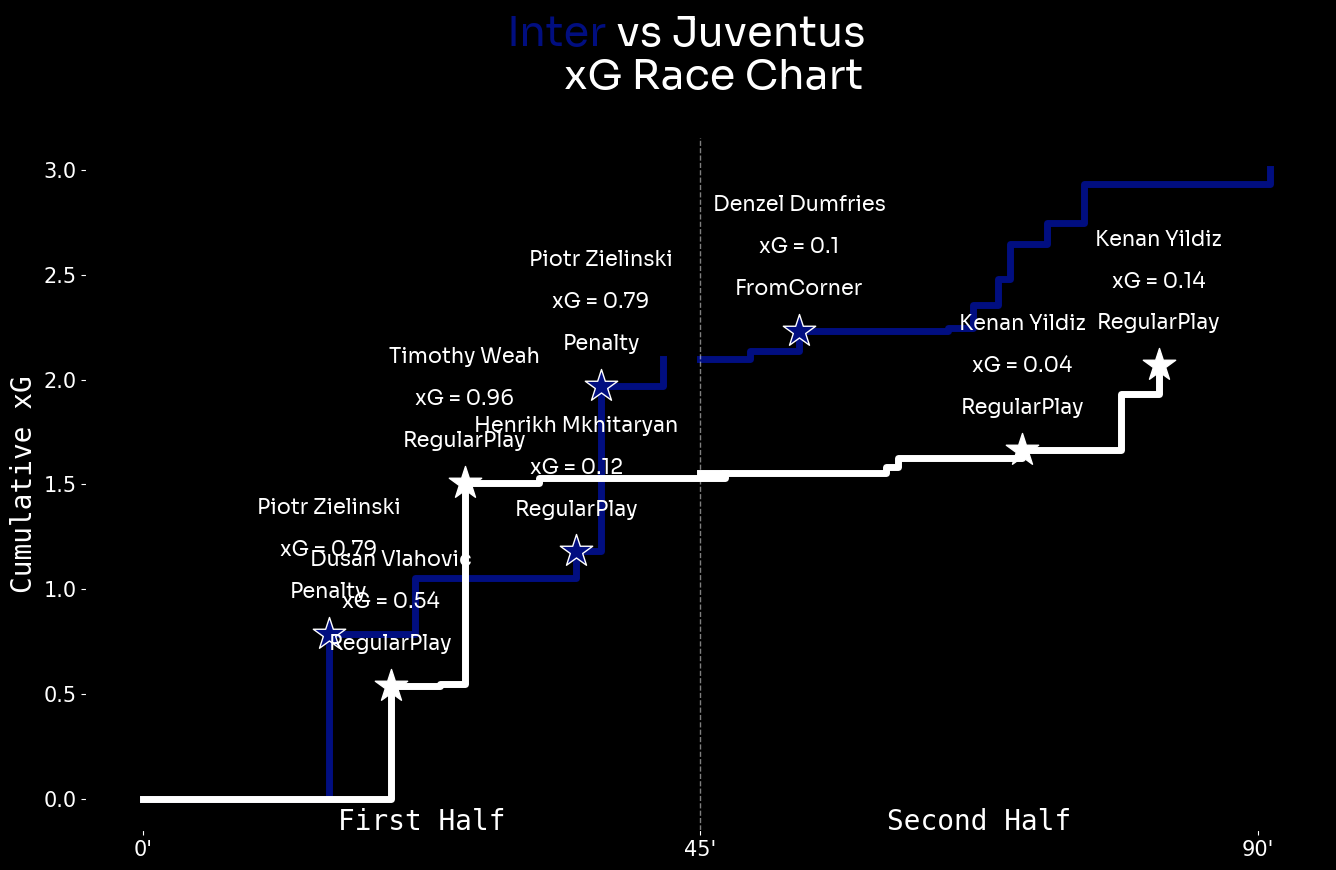

In [97]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.set_facecolor('black')
ax.set_facecolor('black')
# Plot the xG for each team by half
# We want to make it so the lines both start at 0
team2_facecolor = 'white'

for team in df_xG['teamName'].unique():
    
    team_df = df_xG[df_xG['teamName'] == team]
    
    # add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'teamName': team, 'min': 0, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': 0, 'half': 1}, index=[0]), team_df])
    
    # Also add a row at the beginning of the second half to make the lines start where the first half ended
    team_df = pd.concat([team_df[team_df['half'] == 1], pd.DataFrame({'teamName': team, 'min': 45, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': team_df[team_df['half'] == 1]['cumulative_xG'].iloc[-1], 'half': 2}, index=[0]), team_df[team_df['half'] == 2]])

    for half in team_df['half'].unique():
        half_df = team_df[team_df['half'] == half]
        ax.plot(
            half_df['min'], 
            half_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=team2_facecolor if team == hometeam else team1_facecolor,
            linewidth=5
        )   
        

# We Can add a scatter plot to show the goals
for team in df_xG['teamName'].unique():
    team_df = df_xG[(df_xG['teamName'] == team) & (df_xG['eventType'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['min'], 
            x['cumulative_xG'], 
            c=team2_facecolor if team == hometeam else team1_facecolor,
            edgecolor='white',
            s=600,
            marker='*',
            # We want the goals to be on top of the lines
            zorder=5
        )
        
        # add a label to the goals for the player who scored
        ax.text(
            x['min'], 
            x['cumulative_xG'] + .6, 
            x['playerName'], 
            ha='center', 
            va='center',
            c='white',
            fontfamily='monospace', 
            fontsize=15,
            fontproperties=font_prop,
            zorder=10
        )
        # add a label to the goals for the player who scored
        ax.text(
            x['min'], 
            x['cumulative_xG'] + .4, 
            f"xG = {round(x['expectedGoals'],2)}", 
            ha='center', 
            va='center',
            c='white',
            fontfamily='monospace', 
            fontsize=15,
            fontproperties=font_prop,
            zorder=10
        )
        ax.text(
            x['min'], 
            x['cumulative_xG'] + .2, 
            x['situation'], 
            ha='center', 
            va='center',
            c='white',
            fontfamily='monospace', 
            fontsize=15,
            fontproperties=font_prop,
            zorder=10
        )
        
# Let's label the x axis with first and second half
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''])

# Lets add the actual words "First Half" and "Second Half" to the plot under the x axis
ax.text(22.5, -.15, 'First Half', ha='center', fontfamily='monospace', fontsize=20,color='white')
ax.text(67.5, -.15, 'Second Half', ha='center', fontfamily='monospace', fontsize=20,color='white')
#ax.text(107.5, -.25, 'Extra Time', ha='center', fontfamily='monospace', fontsize=20,color='white')

# Let's label the y axis with the cumulative xG
ax.set_ylabel('Cumulative xG', fontfamily='monospace', fontsize=20,color='white')

# Let's get rid of the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

#ax.grid(False, which='both', color='gray', linestyle='--', linewidth=0.5)
#ax.tick_params(axis='both', which='both', length=0)

ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)

ax.axvline(x=45, color='white', linestyle='--', linewidth=1,alpha=0.5)


# Let's change the color of the title to show which team is which using the highlight-text package
from highlight_text import fig_text

fig_text(
    0.5,
    0.97,
    '<Inter> vs <Juventus>\n      xG Race Chart', 
    fontsize=30, 
    ha='center', 
    va='center', 
    ax=ax,
    color='white',
    fontfamily='monospace',
    fontproperties=font_prop,
    highlight_textprops=[{'color': team1_facecolor}, {'color': team2_facecolor}]
)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/2.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PassingNetworks

In [98]:
df['teamName'].unique()

array(['Juventus', 'Inter'], dtype=object)

In [99]:
team1_name = 'Inter'
team2_name = 'Juventus'

In [100]:
import matplotlib.patheffects as path_effects
from matplotlib.colors import to_rgba

def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY", "teamName", "playerId", "receiver", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes

passes_df = get_passes_df(df)
path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]

def passing_stats(teamName, df):
    dfpass = df[(df['teamName'] == teamName) & (df['type'] == 'Pass')]

    total_passes = dfpass.shape[0]
    acc_pass = dfpass[dfpass['outcomeType'] == 'Successful']
    through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Crosses = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX'] >= 88.5) & (acc_pass['endY'] >= 13.6) & (acc_pass['endY'] <= 54.4) & 
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]

    return total_passes, acc_pass.shape[0], Lng_ball.shape[0], Crosses.shape[0], pen_box.shape[0]

def get_passes_between_df(teamName, passes_df, players_df):
    passes_df = passes_df[(passes_df["teamName"] == teamName)]
    # df = pd.DataFrame(events_dict)
    dfteam = df[(df['teamName'] == teamName) & (~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card'))]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    average_locs_and_count_df['name'] = average_locs_and_count_df['name'].apply(unidecode)
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['index', 'playerId', 'receiver', 'teamName']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).index.count().reset_index()
    passes_between_df.rename({'index': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

# home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(team1_name, passes_df, players_df)
# away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(team2_name, passes_df, players_df)

C:\Users\acer\AppData\Local\Temp\ipykernel_2820\3402549095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "receiver"] = df["playerId"].shift(-1)


In [103]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, teamName, flipped=False):
    MAX_LINE_WIDTH = 15
    MAX_MARKER_SIZE = 3000
    line_color='white'
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = VerticalPitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)
    ax.set_aspect('equal')
    #ax.set_xlim(-0.5, 105.5)
    #ax.set_ylim(-0.5, 68.5)

    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)
    #ax.text(0.5,1,f"Passing Networks\nStarting 11", color=line_color,fontproperties=font_prop, size=30,ha='center', transform=ax.transAxes)
    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=background, edgecolor=line_color, linewidth=2, alpha=1, ax=ax)
      #else:
        #pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=900, marker='s', color=background, edgecolor=line_color, linewidth=2, alpha=0.7, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True:
            player_initials = row["shirtNo"]
            pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=18, ax=ax)

    # Defense line Passing Height (avg. height of all the passes made by the Center Backs)
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['pass_avg_x'].median(), 2)
    #ax.axvline(x=def_line_h, color='white', linestyle='dotted', alpha=0.7, linewidth=2)

    # Getting the top passers combination
    passes_between_df = passes_between_df.sort_values(by='pass_count', ascending=False).head(1).reset_index(drop=True)
    most_pass_from = passes_between_df['name'][0]
    most_pass_from_no = passes_between_df['shirtNo'][0]
    most_pass_to = passes_between_df['name_end'][0]
    most_pass_to_no = passes_between_df['shirtNo_end'][0]
    most_pass_count = passes_between_df['pass_count'][0]

    # Heading and other texts
    if teamName == team2_name:
      # inverting the pitch for away team
      ax.invert_xaxis()
      ax.invert_yaxis()

        

    
    # Headlines and other texts
    if teamName == team1_name:
      # Adding text below the pitch by setting a transform and adjusting the y position.
        ax.text(0.75, -0.05, f"Average On Ball Defensive Line = {def_line_h}m", color='white',fontproperties=font_prop, size=12,ha='right', transform=ax.transAxes)
        ax.text(1, -0.1, f"{most_pass_from} ({most_pass_from_no}) to {most_pass_to} ({most_pass_to_no}) {most_pass_count} Passes", color='white',fontproperties=font_prop, size=12,ha='right', transform=ax.transAxes)
        ax.text(0.5,1,f"{team1_name}\nPassing Network\nStarting 11", color=line_color,fontproperties=font_prop, size=25,ha='center', transform=ax.transAxes)
    else:
      #ax.text(2,2, "circle = starter\nbox = sub", color=team2_facecolor, size=12, ha='right', va='top')
      ax.text(0.9, -0.05, f"Average On Ball Defensive Line = {def_line_h}m", color='white',fontproperties=font_prop, size=12,ha='right', transform=ax.transAxes)
      ax.text(0.9, -0.1, f"{most_pass_from} ({most_pass_from_no}) to {most_pass_to} ({most_pass_to_no}) {most_pass_count} Passes", color='white',fontproperties=font_prop, size=12,ha='right', transform=ax.transAxes)
      ax.text(0.5,1,f"{team2_name}\nPassing Network\nStarting 11", color=line_color,fontproperties=font_prop, size=25,ha='center', transform=ax.transAxes)

    # returnig the stats for storing those 
    return {
        'Team_Name': teamName,
        #'Defense_Line_Height': def_line_h,
        #'Vericality_%': verticality,
        'Most_pass_combination_from': most_pass_from,
        'Most_pass_combination_to': most_pass_to,
        'Most_passes_in_combination': most_pass_count,
    }

def plot_donut_charts(ax, action_types, team_a_stats, team_b_stats, team1, team2):
    # Ensure the main axis background is black
    ax.set_facecolor('black')

    # Number of action types
    num_actions = len(action_types)
    
    # Loop through each action and create a new donut chart in a vertically stacked layout
    for i, action in enumerate(action_types):
        # Create a smaller inset axis for each donut, adjust its vertical position
        inset_ax = ax.inset_axes([0.3, 1 - (i+1) * 1.0 / num_actions, 0.4, 0.2])
        
        sizes = [team_a_stats[i], team_b_stats[i]]
        labels = [team_a_stats[i], team_b_stats[i]]
        colors = [team1_facecolor, team2_facecolor]  # Assign distinct colors to teams
        
        wedges, texts = inset_ax.pie(
            sizes, 
            labels=labels, 
            startangle=90, 
            colors=colors, 
            wedgeprops=dict(width=0.2),  # Adjust width for thicker donut
            textprops={'color': 'white', 'fontsize': 12}
        )
        
        # Add a circle for the donut hole
        circle = plt.Circle((0, 0), 0.7, color='black', fc='black')
        inset_ax.add_artist(circle)
        
        # Add action label at the center
        inset_ax.text(0, 0, action, horizontalalignment='center', verticalalignment='center', 
                      fontsize=12, fontweight='bold', color='white',fontproperties=font_prop)
        
        # Set equal aspect ratio and hide the axes
        inset_ax.axis('equal')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])

    ax.axis('off')

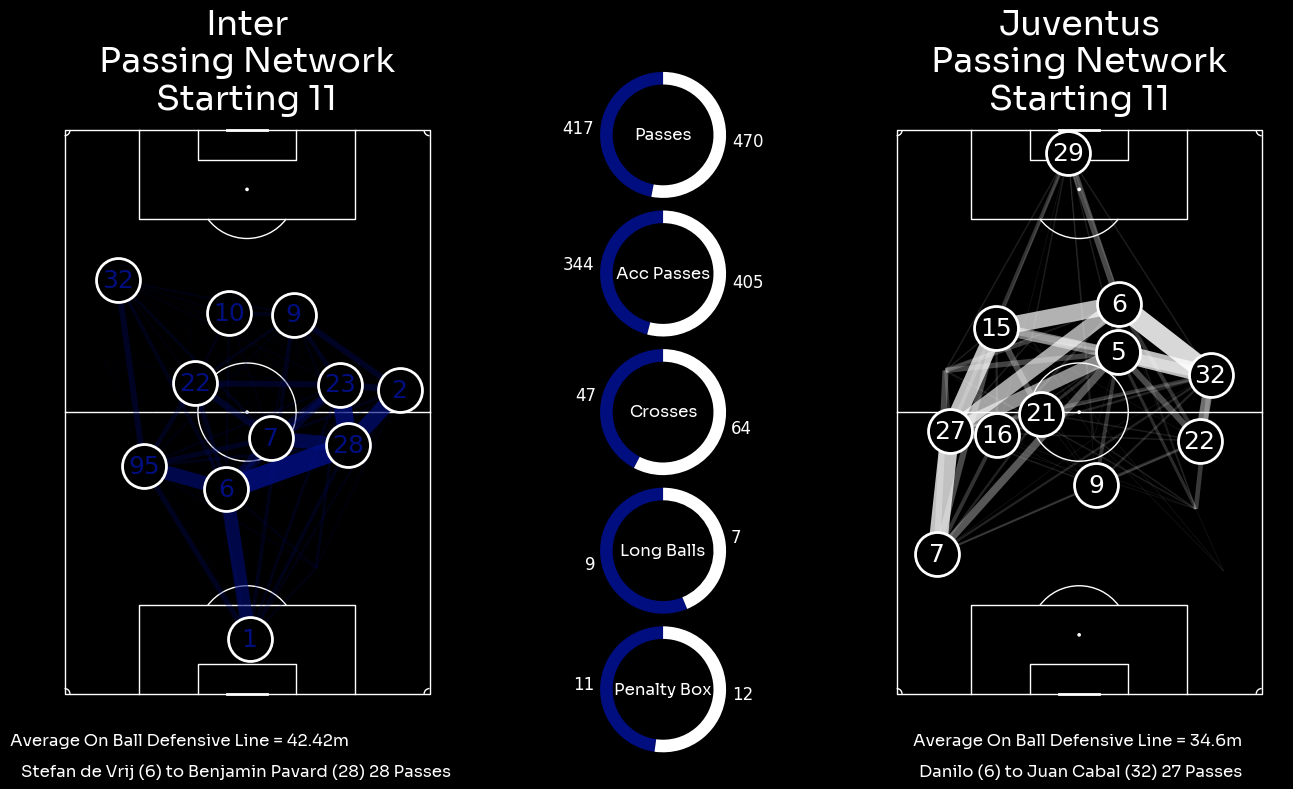

In [105]:
fig,axs=plt.subplots(1,3, figsize=(16,9), facecolor=background)
plt.subplots_adjust(wspace=0.02)
pass_network_stats_home = pass_network_visualization(axs[0], home_passes_between_df, home_average_locs_and_count_df, team1_facecolor, team1_name)
pass_network_stats_away = pass_network_visualization(axs[2], away_passes_between_df, away_average_locs_and_count_df, team2_facecolor, team2_name)
action_types = ['Passes', 'Acc Passes', 'Crosses', 'Long Balls', 'Penalty Box']
plot_donut_charts(axs[1],action_types,passing_stats(team1_name,df),passing_stats(team2_name,df),team1_name,team2_name)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/3.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Dominated Zones

C:\Users\acer\AppData\Local\Temp\ipykernel_2820\2170938484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\acer\AppData\Local\Temp\ipykernel_2820\2170938484.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


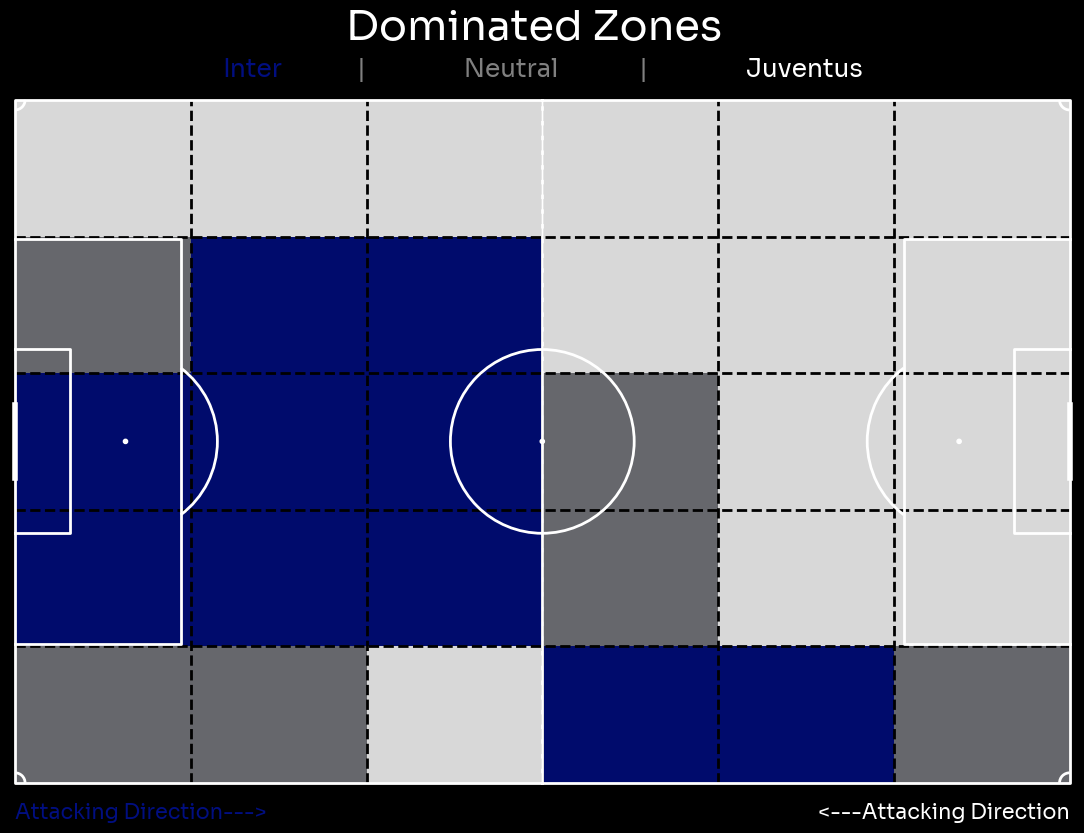

In [106]:
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import ax_text, fig_text
def plot_congestion(ax):
    # Comparing open play touches of both teams in each zones of the pitch, if more than 55% touches for a team it will be coloured of that team, otherwise gray to represent contested
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [team2_facecolor, 'gray', team1_facecolor], N=20)
    df1 = df[(df['teamName']==team1_name) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2 = df[(df['teamName']==team2_name) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2['x'] = 105-df2['x']
    df2['y'] =  68-df2['y']
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=2, line_zorder=6)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    bin_statistic1 = pitch.bin_statistic(df1.x, df1.y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(df2.x, df2.y, bins=(6,5), statistic='count', normalize=False)

    # Assuming 'cx' and 'cy' are as follows:
    cx = np.array([[ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25]])

    cy = np.array([[61.2, 61.2, 61.2, 61.2, 61.2, 61.2],
               [47.6, 47.6, 47.6, 47.6, 47.6, 47.6],
               [34.0, 34.0, 34.0, 34.0, 34.0, 34.0],
               [20.4, 20.4, 20.4, 20.4, 20.4, 20.4],
               [ 6.8,  6.8,  6.8,  6.8,  6.8,  6.8]])

    # Flatten the arrays
    cx_flat = cx.flatten()
    cy_flat = cy.flatten()

    # Create a DataFrame
    df_cong = pd.DataFrame({'cx': cx_flat, 'cy': cy_flat})

    hd_values = []
    # Loop through the 2D arrays
    for i in range(bin_statistic1['statistic'].shape[0]):
        for j in range(bin_statistic1['statistic'].shape[1]):
            stat1 = bin_statistic1['statistic'][i, j]
            stat2 = bin_statistic2['statistic'][i, j]

            if (stat1 / (stat1 + stat2)) > 0.55:
                hd_values.append(1)
            elif (stat1 / (stat1 + stat2)) < 0.45:
                hd_values.append(0)
            else:
                hd_values.append(0.5)

    df_cong['hd']=hd_values
    bin_stat = pitch.bin_statistic(df_cong.cx, df_cong.cy, bins=(6,5), values=df_cong['hd'], statistic='sum', normalize=False)
    pitch.heatmap(bin_stat, ax=ax, cmap=pcmap, edgecolors='#000000', lw=0, zorder=3, alpha=0.85)

    ax_text(52.5, 71, s=f"<{team1_name}>             |                 Neutral              |                 <{team2_name}>", highlight_textprops=[{'color':team1_facecolor}, {'color':team2_facecolor}],
            color='gray', fontsize=18, ha='center', va='center',font_properties=font_prop, ax=ax)
    ax.text(33,74,"Dominated Zones", color='white', fontsize=30, fontweight='bold',font_properties=font_prop)
    ax.text(0,  -3, 'Attacking Direction--->', color=team1_facecolor, fontsize=15, ha='left', va='center',font_properties=font_prop)
    ax.text(105,-3, '<---Attacking Direction', color=team2_facecolor, fontsize=15, ha='right', va='center',font_properties=font_prop)

    ax.vlines(1*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(2*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(3*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(4*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(5*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)

    ax.hlines(1*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(2*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(3*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(4*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)

    return

fig,ax=plt.subplots(figsize=(16,9), facecolor=background)
plot_congestion(ax)
fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/4.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Final Third Entries

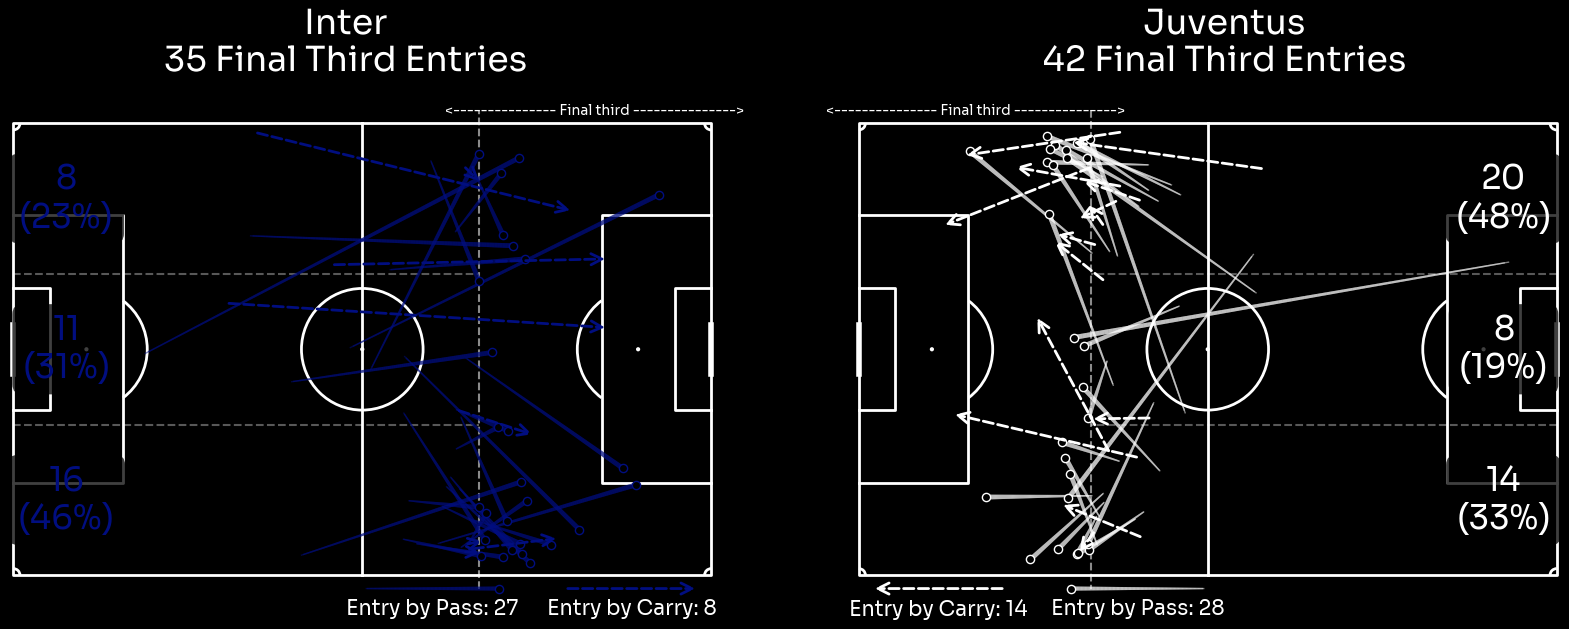

In [107]:
def Final_third_entry(ax, team_name, col):
    # Final third Entry means passes or carries which has started outside the Final third and ended inside the final third
    dfpass = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['x']<70) & (df['endX']>=70) & (df['outcomeType']=='Successful') &
                (~df['qualifiers'].str.contains('Freekick'))]
    dfcarry = df[(df['teamName']==team_name) & (df['type']=='Carry') & (df['x']<70) & (df['endX']>=70)]
    pitch = Pitch(pitch_type='uefa', pitch_color=background, line_color='white', linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == team2_name:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pass_count = len(dfpass) + len(dfcarry)

    # calculating the counts
    left_entry = len(dfpass[dfpass['y']>=45.33]) + len(dfcarry[dfcarry['y']>=45.33])
    mid_entry = len(dfpass[(dfpass['y']>=22.67) & (dfpass['y']<45.33)]) + len(dfcarry[(dfcarry['y']>=22.67) & (dfcarry['y']<45.33)])
    right_entry = len(dfpass[(dfpass['y']>=0) & (dfpass['y']<22.67)]) + len(dfcarry[(dfcarry['y']>=0) & (dfcarry['y']<22.67)])
    left_percentage = round((left_entry/pass_count)*100)
    mid_percentage = round((mid_entry/pass_count)*100)
    right_percentage = round((right_entry/pass_count)*100)

    ax.hlines(22.67, xmin=0, xmax=70, colors='white', linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=70, colors='white', linestyle='dashed', alpha=0.35)
    ax.vlines(70, ymin=-2, ymax=70, colors='white', linestyle='dashed', alpha=0.55)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=background, alpha=0.75)
    if col == team1_facecolor:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=team1_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=team1_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=team1_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
    else:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=team2_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=team2_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=team2_facecolor, fontsize=24, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)

    # plotting the passes
    pro_pass = pitch.lines(dfpass.x, dfpass.y, dfpass.endX, dfpass.endY, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpass.endX, dfpass.endY, s=35, edgecolor=col, linewidth=1, color=background, zorder=2, ax=ax)
    # plotting carries
    for index, row in dfcarry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pass_count} Final Third Entries"

    # Heading and other texts
    if col == team1_facecolor:
        ax.text(50,80,f"{team1_name}\n{counttext}", color='white', fontsize=25, fontweight='bold',ha='center', va='center', path_effects=path_eff,fontproperties=font_prop)
        ax.text(87.5, 70, '<--------------- Final third --------------->', color='white', ha='center', va='center',fontproperties=font_prop)
        pitch.lines(53, -2, 73, -2, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,-2, s=35, edgecolor=col, linewidth=1, color=background, zorder=2)
        arrow = patches.FancyArrowPatch((83, -2), (103, -2), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, -5, f'Entry by Pass: {len(dfpass)}', fontsize=15, color='white', ha='center', va='center',fontproperties=font_prop)
        ax.text(93, -5, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color='white', ha='center', va='center',fontproperties=font_prop)

    else:
        ax.text(50,-12,f"{team2_name}\n{counttext}", color='white', fontsize=25, fontweight='bold',ha='center', va='center', path_effects=path_eff,fontproperties=font_prop)
        ax.text(87.5, -2, '<--------------- Final third --------------->', color='white', ha='center', va='center',fontproperties=font_prop)
        pitch.lines(53, 70, 73, 70, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,70, s=35, edgecolor=col, linewidth=1, color=background, zorder=2)
        arrow = patches.FancyArrowPatch((83, 70), (103, 70), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, 73, f'Entry by Pass: {len(dfpass)}', fontsize=15, color='white', ha='center', va='center',fontproperties=font_prop)
        ax.text(93, 73, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color='white', ha='center', va='center',fontproperties=font_prop)

    return {
        'Team_Name': team_name,
        'Total_Final_Third_Entries': pass_count,
        'Final_Third_Entries_From_Left': left_entry,
        'Final_Third_Entries_From_Center': mid_entry,
        'Final_Third_Entries_From_Right': right_entry,
        'Entry_By_Pass': len(dfpass),
        'Entry_By_Carry': len(dfcarry)
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=background)
final_third_entry_stats_home = Final_third_entry(axs[0], team1_name, team1_facecolor)
final_third_entry_stats_away = Final_third_entry(axs[1], team2_name, team2_facecolor)

fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/5.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Defensive Actions

In [108]:
def get_defensive_action_df(events_dict):
    # filter only defensive actions
    defensive_actions_ids = df.index[(df['type'] == 'Aerial') & (df['qualifiers'].str.contains('Defensive')) |
                                     (df['type'] == 'BallRecovery') |
                                     (df['type'] == 'BlockedPass') |
                                     (df['type'] == 'Challenge') |
                                     (df['type'] == 'Clearance') |
                                     (df['type'] == 'Error') |
                                     (df['type'] == 'Foul') |
                                     (df['type'] == 'Interception') |
                                     (df['type'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["index", "x", "y", "teamName", "playerId", "type", "outcomeType"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def calculate_event_types(dataframe, event_types=None):
    # Group by 'teamName' and 'type', then count occurrences
    event_counts = dataframe.groupby(['teamName', 'type']).size().reset_index(name='count')
    
    # If event_types is provided, filter the event_counts DataFrame
    if event_types is not None:
        event_counts = event_counts[event_counts['type'].isin(event_types)]
    
    # Create a dictionary to hold the results
    results = {}
    
    # Populate the dictionary with team names and their event types and counts
    for team in event_counts['teamName'].unique():
        team_data = event_counts[event_counts['teamName'] == team]
        results[team] = {
            'types': team_data['type'].tolist(),
            'counts': team_data['count'].tolist()
        }
    
    return results

desired_event_types = ['Aerial', 'BallRecovery','Challenge','Interception', 'Tackle']
result = calculate_event_types(df, event_types=desired_event_types)
team1_def_stats = []
team2_def_stats = []
for team, data in result.items():
    if team == team1_name:
        team1_def_stats.append(data['counts'])
    else:
        team2_def_stats.append(data['counts'])
team1_def_stats = [item for sublist in team1_def_stats for item in sublist]
team2_def_stats = [item for sublist in team2_def_stats for item in sublist]

def get_da_count_df(team_name, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(team1_name, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(team2_name, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position'] != 'GK']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position'] != 'GK']

def defensive_block(ax, average_locs_and_count_df, team_name, col):
    defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=background, line_color='white', linewidth=2, line_zorder=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_facecolor(background)
    #ax.set_xlim(-0.5, 105.5)
    #ax.set_ylim(-0.5, 68.5)
    color = np.array(to_rgba(col))
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [background, col], N=500)
    kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

    average_locs_and_count_df = average_locs_and_count_df.reset_index(drop=True)
    da_scatter = pitch.scatter(defensive_actions_team_df.x, defensive_actions_team_df.y, s=10, marker='x', color='white', alpha=0.5, ax=ax)

    # Headings and other texts
    if team_name == team2_name:
        ax.invert_xaxis()
        ax.invert_yaxis()

    # Headlines and other texts
    if team_name == team1_name:
        ax.text(35,110,f"{team1_name}\nDefensive Actions", color='white', fontsize=25, fontproperties=font_prop,ha='center')
    else:
        ax.text(36,-5,f"{team2_name}\nDefensive Actions", color='white', fontsize=25, fontproperties=font_prop,ha='center')

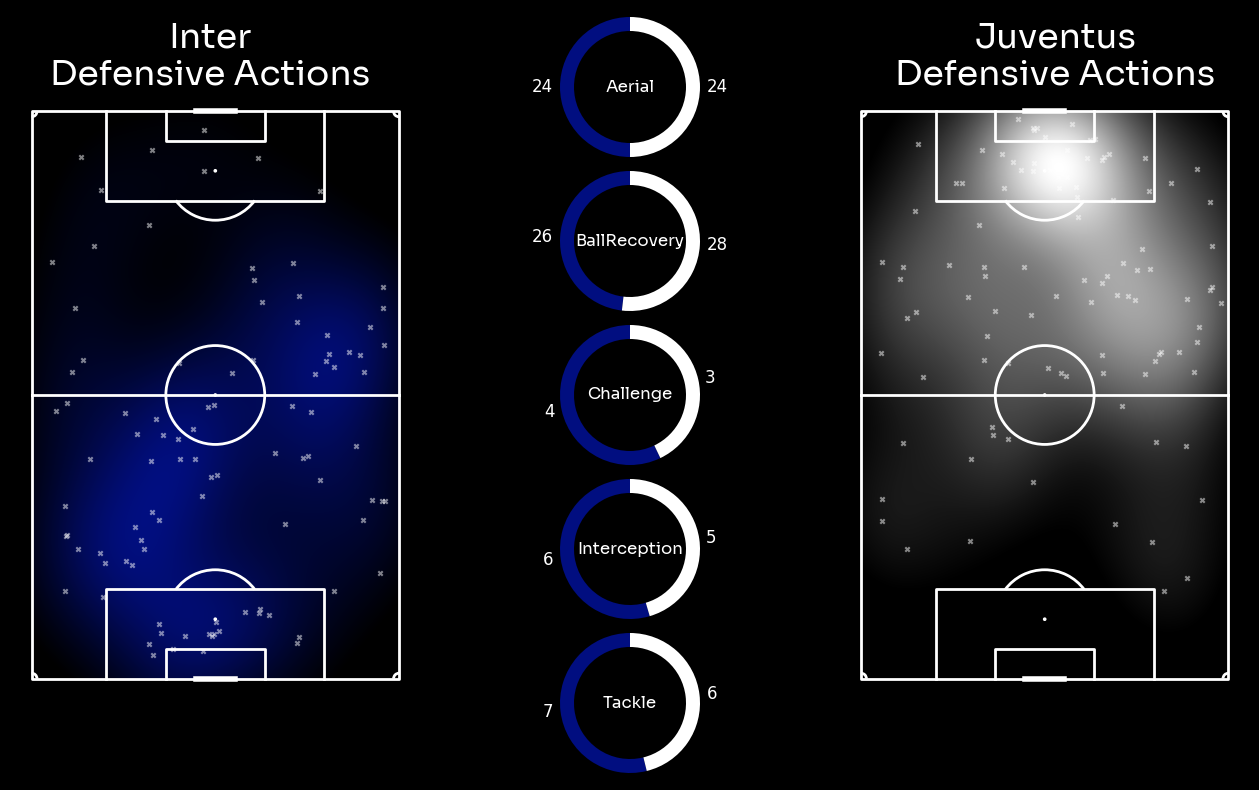

In [110]:
fig,axs=plt.subplots(1,3, figsize=(16,10), facecolor=background)
defensive_block_stats_home = defensive_block(axs[0], defensive_home_average_locs_and_count_df, team1_name, team1_facecolor)
defensive_block_stats_away = defensive_block(axs[2], defensive_away_average_locs_and_count_df, team2_name, team2_facecolor)
action_types_def = ['Aerial', 'BallRecovery','Challenge','Interception', 'Tackle']

plot_donut_charts(axs[1],action_types_def,team1_def_stats,team2_def_stats,team1_name,team2_name)
fig.subplots_adjust(wspace=0.01)

fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/6.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Player Analysis

### Passmap

In [111]:
df['name'].unique()

array(['nan', 'Dusan Vlahovic', 'Manuel Locatelli', 'Francisco Conceicao',
       'Pierre Kalulu', 'Danilo', 'Juan Cabal', 'Andrea Cambiaso',
       'Alessandro Bastoni', 'Nicolo Fagioli', 'Weston McKennie',
       'Stefan de Vrij', 'Marcus Thuram', 'Yann Sommer',
       'Benjamin Pavard', 'Denzel Dumfries', 'Nicolo Barella',
       'Piotr Zielinski', 'Henrikh Mkhitaryan', 'Federico Dimarco',
       'Michele Di Gregorio', 'Timothy Weah', 'Lautaro Martinez',
       'Nicolo Savona', 'Kenan Yildiz', 'Davide Frattesi', 'Yann Bisseck',
       'Samuel Mbangula', 'Federico Gatti', 'Matteo Darmian',
       'Khephren Thuram', 'Mehdi Taremi'], dtype=object)

In [122]:
team1_facecolor = '#010E80'

In [123]:
def player_passMap(ax, pname):
    pitch = VerticalPitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    #ax.set_xlim(-0.5, 105.5)
    #ax.set_ylim(-0.5, 68.5)

    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']

    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0

    #pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
    #                    (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball'))]
    through_pass_acc = through_pass[through_pass['outcomeType']=='Successful']
    long_pass = dfpass[(dfpass['qualifiers'].str.contains('Longball'))]
    long_pass_acc = long_pass[long_pass['outcomeType']=='Successful']
    cross = dfpass[(dfpass['qualifiers'].str.contains('Cross'))]
    cross_acc = cross[cross['outcomeType']=='Successful']
    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') &
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    #shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    assist = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) &
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    corners_acc = corners[corners['outcomeType']=='Successful']
    freekick = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    freekick_acc = freekick[freekick['outcomeType']=='Successful']
    throws = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    throws_acc = throws[throws['outcomeType']=='Successful']

    df_xT_inc = dfpass[dfpass['xT']>0]
    df_xT_dec = dfpass[dfpass['xT']<0]
    xT_by_Pass = dfpass['xT'].sum().round(2)

    #pitch.lines(iac_pass.y, iac_pass.x, iac_pass.endY, iac_pass.endX, color='grey', lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='grey', lw=1, alpha=0.3, comet=False, zorder=2, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='green',  lw=2, alpha=0.8,comet=False, zorder=4, ax=ax)
    pitch.lines(assist.x, assist.y, assist.endX, assist.endY, color=team1_facecolor, lw=3, alpha=1,comet=False, zorder=5, ax=ax)
    pitch.lines(long_pass.x, long_pass.y, long_pass.endX, long_pass.endY, color='red', lw=1, alpha=0.5,comet=False, zorder=3, ax=ax)
    pitch.lines(fnl_thd.x, fnl_thd.y, fnl_thd.endX, fnl_thd.endY, color='yellow', lw=1, alpha=0.5,comet=False, zorder=3, ax=ax)
    
    ax.scatter(acc_pass.endY, acc_pass.endX, s=50, color=background,edgecolor='white', alpha=0.5, zorder=2)
    ax.scatter(key_pass.endY, key_pass.endX, s=100, color=background,edgecolor='green', alpha=0.8, zorder=4)
    ax.scatter(assist.endY, assist.endX, s=100, color=background,edgecolor=team1_facecolor, alpha=1, zorder=5)
    ax.scatter(fnl_thd.endY, fnl_thd.endX, s=100, color=background,edgecolor='yellow', alpha=0.5, zorder=3)
    ax.scatter(long_pass.endY, long_pass.endX, s=100, color=background,edgecolor='red', alpha=0.5, zorder=3)

    ax.text(30,110,f"{pname}'s PassMap", color='white', fontsize=25,fontproperties=font_prop)
    ax_text(0, 75, f'''
    <Accurate Passes: {len(acc_pass)}/{len(dfpass)} ({accurate_pass_perc}%)> \n\n
    <Assists: {len(assist)}>\n\n
    <Final third Passes: {len(fnl_thd)}> \n\n
    <Longballs (Acc.): {len(long_pass)} ({len(long_pass_acc)})> \n\n
    Passes into Penalty box: {len(pen_box)} \n\n
    Crosses (Acc.): {len(cross)} ({len(cross_acc)}) \n\n
    Chances Created: {len(key_pass)}\n\n
    xT from Pass: {xT_by_Pass}
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':team1_facecolor}, {'color':'green'}, {'color':'yellow'},{'color':'red'}], fontsize=20, ha='left', va='center', ax=ax)
    
    return

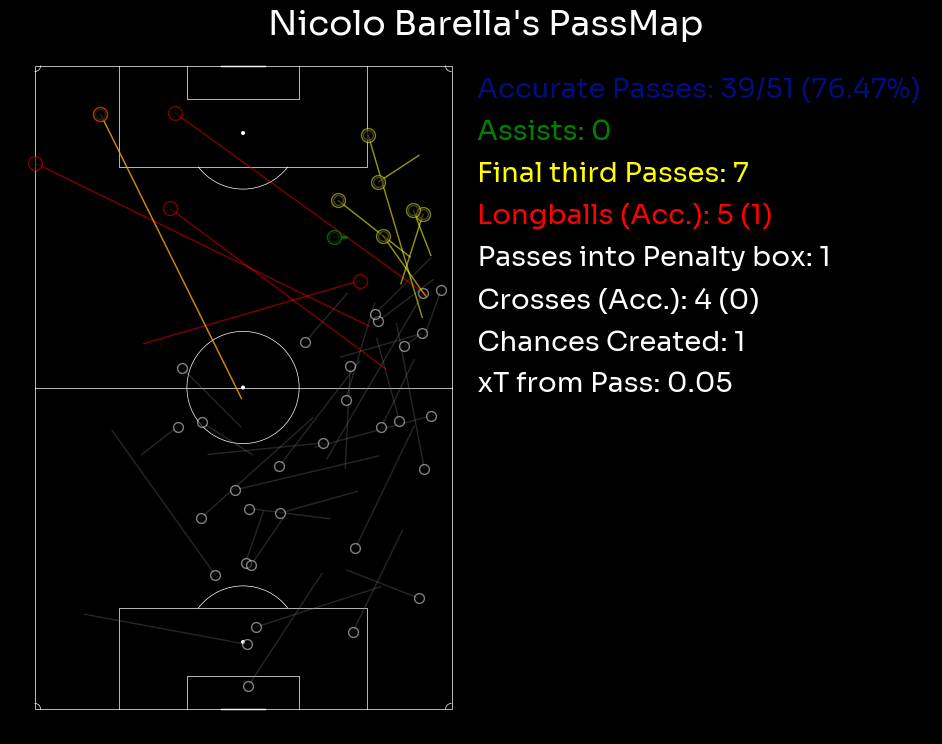

In [125]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
pname = 'Nicolo Barella'
player_passMap(ax, pname)
fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/InterVJuve/8.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### ShotMap

In [ ]:
def Individual_ShotMap(ax,pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5,105.5)
    ax.set_ylim(-0.5, 68.5)

    # goal = df[(df['name']==pname) & (df['type']=='Goal') & (~df['qualifiers'].str.contains('BigChance'))]
    # miss = df[(df['name']==pname) & (df['type']=='MissedShots') & (~df['qualifiers'].str.contains('BigChance'))]
    # save = df[(df['name']==pname) & (df['type']=='SavedShot') & (~df['qualifiers'].str.contains('BigChance'))]
    # post = df[(df['name']==pname) & (df['type']=='ShotOnPost') & (~df['qualifiers'].str.contains('BigChance'))]

    op_sh = shots_df[(shots_df['playerName']==pname) & (shots_df['situation']=='RegularPlay')]

    goal = shots_df[(shots_df['playerName']==pname) & (shots_df['eventType']=='Goal')]
    miss = shots_df[(shots_df['playerName']==pname) & (shots_df['eventType']=='Miss')]
    save = shots_df[(shots_df['playerName']==pname) & (shots_df['eventType']=='AttemptSaved') & (shots_df['isBlocked']==0)]
    blok = shots_df[(shots_df['playerName']==pname) & (shots_df['eventType']=='AttemptSaved') & (shots_df['isBlocked']==1)]
    post = shots_df[(shots_df['playerName']==pname) & (shots_df['eventType']=='Post')]

    goal_bc = df[(df['name']==pname) & (df['type']=='Goal') & (df['qualifiers'].str.contains('BigChance'))]
    miss_bc = df[(df['name']==pname) & (df['type']=='MissedShots') & (df['qualifiers'].str.contains('BigChance'))]
    save_bc = df[(df['name']==pname) & (df['type']=='SavedShot') & (df['qualifiers'].str.contains('BigChance'))]
    post_bc = df[(df['name']==pname) & (df['type']=='ShotOnPost') & (df['qualifiers'].str.contains('BigChance'))]

    shots = df[(df['name']==pname) & ((df['type']=='Goal') | (df['type']=='MissedShots') | (df['type']=='SavedShot') | (df['type']=='ShotOnPost'))]
    out_box = shots[shots['qualifiers'].str.contains('OutOfBox')]
    shots = shots.copy()
    shots.loc[:, 'Length'] = np.sqrt((shots['x'] - 105)**2 + (shots['y'] - 34)**2)
    avg_dist = round(shots['Length'].mean(), 2)
    xG = shots_df[(shots_df['playerName']==pname)]['expectedGoals'].sum().round(2)
    xGOT = shots_df[(shots_df['playerName']==pname)]['expectedGoalsOnTarget'].sum().round(2)

    pitch.scatter(goal.x,goal.y, s=goal['expectedGoals']*1000+100, marker='football', c='None', edgecolors='green', zorder=5, ax=ax)
    pitch.scatter(post.x,post.y, s=post['expectedGoals']*1000+100, marker='o', c='None', edgecolors=hcol, hatch='+++', zorder=4, ax=ax)
    pitch.scatter(blok.x,blok.y, s=blok['expectedGoals']*1000+100, marker='o', c='None', edgecolors=hcol, hatch='/////', zorder=4, ax=ax)
    pitch.scatter(save.x,save.y, s=save['expectedGoals']*1000+100, marker='o', c=hcol, edgecolors=line_color, zorder=3, ax=ax)
    pitch.scatter(miss.x,miss.y, s=miss['expectedGoals']*1000+100, marker='o', c='None', edgecolors=hcol, zorder=2, ax=ax)

    # pitch.scatter(goal_bc.x,goal_bc.y, s=250, marker='football', c='None', edgecolors='green', zorder=5, ax=ax)
    # pitch.scatter(post_bc.x,post_bc.y, s=190, marker='o', c='None', edgecolors=hcol, hatch='/////', zorder=4, ax=ax)
    # pitch.scatter(save_bc.x,save_bc.y, s=190, marker='o', c=hcol, edgecolors=line_color, zorder=3, ax=ax)
    # pitch.scatter(miss_bc.x,miss_bc.y, s=165, marker='o', c='None', edgecolors=hcol, zorder=2, ax=ax)

    yhalf = [-0.5, -0.5, 68.5, 68.5]
    xhalf = [-0.5, 52.5, 52.5, -0.5]
    ax.fill(xhalf, yhalf, bg_color, alpha=1)

    pitch.scatter(2,56-(0*4), s=200, marker='football', c='None', edgecolors='green', zorder=5, ax=ax)
    pitch.scatter(2,56-(1*4), s=150, marker='o', c='None', edgecolors=hcol, hatch='+++', zorder=4, ax=ax)
    pitch.scatter(2,56-(2*4), s=150, marker='o', c=hcol, edgecolors=line_color, zorder=3, ax=ax)
    pitch.scatter(2,56-(3*4), s=130, marker='o', c='None', edgecolors=hcol, zorder=2, ax=ax)
    pitch.scatter(2,56-(4*4), s=130, marker='o', c='None', edgecolors=hcol, hatch='/////', zorder=2, ax=ax)

    ax.text(0, 71, f"Shooting Stats", color=line_color, fontsize=25, fontweight='bold')
    ax.text(7,64-(0*4), f'Total Shots: {len(shots)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(1*4), f'Open-play Shots: {len(op_sh)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(2*4), f'Goals: {len(goal)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(3*4), f'Shot on Post: {len(post)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(4*4), f'Shots on Target: {len(save)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(5*4), f'Shots off Target: {len(miss)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(6*4), f'Shots Blocked: {len(blok)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(7*4), f'Big Chances: {len(goal_bc)+len(miss_bc)+len(save_bc)+len(post_bc)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(8*4), f'Big Chances Missed: {len(miss_bc)+len(save_bc)+len(post_bc)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(9*4), f'Shots outside box: {len(out_box)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(10*4), f'Shots inside box: {len(shots) - len(out_box)}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(11*4), f'Avg. Shot Distance: {avg_dist} m', fontsize=15, ha='left', va='center')
    ax.text(7,64-(12*4), f'xG: {xG}', fontsize=15, ha='left', va='center')
    ax.text(7,64-(13*4), f'xGOT: {xGOT}', fontsize=15, ha='left', va='center')

    ax.text(80, 71, f"Shot Map", color=line_color, fontsize=25, fontweight='bold', ha='center')
    return

# fig,ax=plt.subplots(figsize=(10,10))
# Individual_ShotMap(ax, pname)